In [2]:
%config InlineBackend.figure_format = 'svg'
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
from tqdm import tqdm_notebook as tqdm
import pandas as pd

DATA_DIR = "../data/gplvm/"

In [3]:
def rbf(X, alpha, beta, gamma):
    
    num_points = X.shape[0]
    
    cov = np.dot(X, X.T)
    diag = np.diag(cov)
    
    # (x_n - x_m)' (x_n - x_m) = x_n'x_n + x_m'x_m - 2x_n'x_m
    cov_ = diag.reshape((num_points, 1)) + diag.reshape((1, num_points)) - 2 * cov
    
    return alpha * np.exp(-gamma / 2.0 * cov_) + np.eye(num_points) / beta


def loglik(K, Y):
    
    D, N = Y.shape
    K_inv = np.linalg.inv(K)

    return -D*N/2*np.log(2*np.pi) - D/2*np.linalg.slogdet(K)[1] - 0.5*np.trace(np.dot(np.dot(K_inv, Y), Y.T))

In [4]:
def fit(Y, latent_dim, alpha, beta, gamma, learn_rate=1e-6, num_iter=10000, verbose=True):
    
    log_every = 100
    
    # Initial guess for X
    pca = PCA(n_components=latent_dim)
    X = pca.fit_transform(Y)

    K = rbf(X, alpha, beta, gamma)
    L = loglik(K, Y)
    
    loglik_grad = grad(lambda X, Y: loglik(rbf(X, alpha, beta, gamma), Y), 0)

    for i in tqdm(range(num_iter)):
        X = X + learn_rate * loglik_grad(X, Y)

        if verbose and i % log_every == 0: 
            print(loglik(rbf(X, alpha, beta, gamma), Y))
    
    return X

In [5]:
latent_dim = 2

# oil dataset
Y = pd.read_csv(DATA_DIR + '/train_data.txt', header=None, sep='\s+').values[:500, :]
labels = (pd.read_csv(DATA_DIR + '/labels.txt', header=None, sep='\s+').values[:500, :]).astype(np.int)

alpha, beta, gamma = 1, 10000, 1
X = fit(Y, latent_dim, alpha, beta, gamma, num_iter=1000, learn_rate=1e-5, verbose=False)

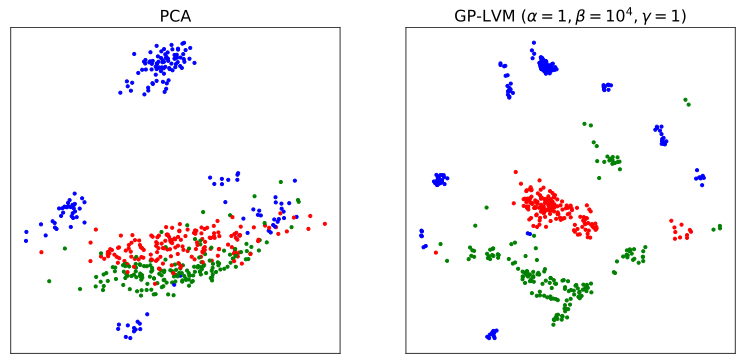

In [7]:
plt.figure(figsize = (13, 6))
plt.subplot(121)
pca = PCA(n_components=latent_dim)
X_pca = pca.fit_transform(Y)
X_pca = X_pca
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, c=np.array(['r', 'g', 'b'])[np.where(labels)[1]])
plt.title('PCA', fontsize=16)
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.scatter(X[:, 0], X[:, 1], s=10, c=np.array(['r', 'g', 'b'])[np.where(labels)[1]])
plt.title('GP-LVM ($\\alpha = 1, \\beta = 10^4, \\gamma = 1$)', fontsize=16)
plt.xticks([])
plt.yticks([])
plt.savefig('clustered.pdf')
plt.show()